# Evaluate TUD

**Write down, what you want to do:**

## 0. Import Stuff

In [1]:
import sys

sys.path.append("../src")

from deep_learning_models import *
from deep_learning_functions import *

import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Dense, Concatenate
from tensorflow.keras.metrics import Precision, Recall


Matplotlib created a temporary config/cache directory at /var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/matplotlib-qi4kyoqg because the default path (/Users/ibemmene/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
from utils import set_allow_gpu_memory_growth

In [3]:
set_allow_gpu_memory_growth(True)

In [4]:
models = [
        ('BiLSTM_Dense', BiLSTMDenseModel()),
        ('BiLSTM_Dense2', BiLSTMDenseModel_2()),
        ('BiLSTM_LSTM_Dense', BiLSTM_LSTMDenseModel()),
        ('BiLSTM_LSTM_doubleDense', BiLSTM_LSTM_doubleDenseModel()),
        ('BiLSTM_doubleDense2', BiLSTM_doubleDenseModel_2),
        #('BiLSTM_LSTM' ,BiLSTM_LSTMModel()),
        ('BiLSTM',BiLSTMModel())
    ]

Metal device set to: Apple M1


2024-01-17 10:13:54.379060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 10:13:54.379141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
SEED = 23

## 1.Evaluate ML Models

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

Eventually this will be done in the ML notebook

### 1.0 Definitions

In [7]:
data_dir = Path("../Daten/data_to_use")
tud_dir = Path("../Daten/TUD")

In [8]:
def load_MLevaluation_data(name, features, testset = "swissdata", return_industry = False):
    
    datanames = [ "brazil_gaz", "japan", "brazil", "ticino", "US", "swissdata"]
    
    
    if name not in datanames + ["all"]:
        print("This is not a dataset ")
        
    if name == "all":
        data_train = []
        data_test = []
        
        data_test.append(pd.read_csv(tud_dir/f"{testset}_train.csv"))
        data_test.append(pd.read_json(tud_dir/f"{testset}_unseen.json"))
        
        df_test = pd.concat(data_test)

        if "complete" in df_test.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                df_test.rename(columns = {"complete": "cartel"}, inplace = True)
                
        df_test = df_test[list(set(features + ["nbids"])) + ["bid", "project", "cartel"]]
        
        datanames.remove(testset)
        for ds in tqdm(datanames):
            df_train = pd.read_json(data_dir/f"{ds}_train.json")
            df_train_unseen = pd.read_json(tud_dir/f"{ds}_unseen.json")
            if "ID" in df_train.keys():
                df_train.rename(columns = {"ID": "project"}, inplace = True)
                df_train_unseen.rename(columns = {"ID": "project"}, inplace = True)
            if "Price" in df_train.keys():
                df_train.rename(columns = {"Price": "bid"}, inplace = True)
                df_train_unseen.rename(columns = {"Price": "bid"}, inplace = True)
            if "complete" in df_train.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                df_train.rename(columns = {"complete": "cartel"}, inplace = True)
                df_train_unseen.rename(columns = {"complete": "cartel"}, inplace = True)
        
                
            df_train["project"] = df_train.project.apply(lambda s: f"{ds}/{s}" )
            df_train_unseen["project"] = df_train_unseen.project.apply(lambda s: f"{ds}/{s}" )
            
            if return_industry:
                df_train["industry"] = ds
                df_train_unseen["industry"] = ds
                
            data_train.append(df_train[list(set(features + ["nbids"])) + ["bid", "project", "cartel"]]) #to make sure nbids is included as it will be needed later
            data_train.append(df_train_unseen[list(set(features + ["nbids"])) + ["bid", "project", "cartel"]])
            
             
        df_train = pd.concat(data_train)
        
        
    else:
        df_train = pd.read_json(data_dir/f"{name}_train.json")
        df_test = pd.read_json(tud_dir/f"{name}_unseen.json")
    
        if "ID" in df_train.keys():
                        df_train.rename(columns = {"ID": "project"}, inplace = True)
                        df_test.rename(columns = {"ID": "project"}, inplace = True)
        if "Price" in df_train.keys():
                        df_train.rename(columns = {"Price": "bid"}, inplace = True)
                        df_test.rename(columns = {"Price": "bid"}, inplace = True)
                    
        df_train = df_train[list(set(features + ["nbids"])) + ["bid", "project", "cartel"]]
        df_test = df_test[list(set(features + ["nbids"])) + ["bid", "project", "cartel"]]
        
        
    df_grouped_train = df_train.groupby(by="project").head(1).reset_index()  
    df_grouped_test = df_test.groupby(by="project").head(1).reset_index() 
    
    df_grouped_train.drop(columns=["bid"], inplace = True)
    df_grouped_train = df_grouped_train.merge(df_train.groupby(by="project")["bid"].apply(list), left_on = "project", right_on = "project")
    df_grouped_test.drop(columns=["bid"], inplace = True)
    df_grouped_test = df_grouped_test.merge(df_test.groupby(by="project")["bid"].apply(list), left_on = "project", right_on = "project")
    
    df_grouped_train["bid"] = df_grouped_train.bid.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped_train["bid"] = df_grouped_train.bid.apply(lambda x: np.sort(x)[::-1])
    df_grouped_test["bid"] = df_grouped_test.bid.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped_test["bid"] = df_grouped_test.bid.apply(lambda x: np.sort(x)[::-1])
    
    padding_length = max(np.asarray(df_grouped_train.nbids.tolist() + df_grouped_test.nbids.tolist()))
    df_grouped_train["bid"] = df_grouped_train.bid.apply(lambda x: np.pad(x, (0,padding_length-len(x))))
    df_grouped_test["bid"] = df_grouped_test.bid.apply(lambda x: np.pad(x, (0,padding_length-len(x))))
    
    df_grouped_train.dropna(inplace = True)
    df_grouped_test.dropna(inplace = True)
    
    df_grouped_train = df_grouped_train.sample(frac = 1, random_state = SEED)
    df_grouped_test = df_grouped_test.sample(frac = 1, random_state = SEED)
    
    X_DL_train = np.array(df_grouped_train.bid.tolist())
    X_DL_train = X_DL_train.reshape(X_DL_train.shape[0], X_DL_train.shape[1], 1)
    X_DL_test = np.array(df_grouped_test.bid.tolist())
    X_DL_test = X_DL_test.reshape(X_DL_test.shape[0], X_DL_test.shape[1], 1)        
           
    X_train = df_grouped_train[features]
    X_test = df_grouped_test[features]
    
    y_train = df_grouped_train["cartel"]
    y_test = df_grouped_test["cartel"]
    
    return X_train, X_test, y_train, y_test, X_DL_train, X_DL_test
    
    

In [9]:
def MLevalTUD(X_train, X_test, y_train, y_test, configuration):
    
    results = []
    
    for name, algo, params in configuration:
    
        pipeline = Pipeline([("scaler", StandardScaler()),(name, algo)])
        pipeline.set_params(**params)
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        results.append(pd.DataFrame({"algorithm": name,
                        "F1": "{:.3f}".format(f1_score(y_test, y_pred)),
                       "precision": "{:.3f}".format(precision_score(y_test, y_pred)),
                       "recall": "{:.3f}".format(recall_score(y_test, y_pred)),
                       "accuracy":  "{:.3f}".format(accuracy_score(y_test, y_pred)),              
                       "params": [params]
                        }))
        
    results = pd.concat(results)
    results = results.reset_index(drop = True)
    
    return results
    

### 1.1 Japan

**with nbids**

In [12]:
features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]

In [14]:
X_train, X_test, y_train, y_test, X_DL_train, X_DL_test = load_MLevaluation_data("japan", features_ML)

In [15]:
conf = pd.read_json("MLresults/japan_nbids_MLresults.json")

In [16]:
conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    #('Poly_SVM', SVC(), {'Poly_SVM__C' : [1.0, 2.5, 5.0, 7.5, 10.0], 'Poly_SVM__kernel' : ['poly'], 'Poly_SVM__degree' : range(1,3), 'Poly_SVM__random_state': [SEED]}),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

**TODO: I'm too lazy to copy all these params, better save the params file in the training process, and load it here!!!**

In [24]:
results_japan_nbids = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)

/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
results_japan_nbids

algorithm     F1 precision recall  \
0          Dummy  0.558     0.549  0.567   
1           Tree  0.915     0.877  0.955   
2         Forest  0.944     0.926  0.962   
3  GradientBoost  0.938     0.920  0.955   
4            MLP  0.899     0.888  0.911   
5       Logistic  0.881     0.870  0.892   
6            SVM  0.928     0.914  0.943   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 2, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 5, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 6, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 1, 'MLP__random_st...  
5  {'Logistic__C': 59.9484250319, 'Logistic__rand...  
6  {'SVM__C': 29.7635144163, 'SVM__gamma': 0.4641...

In [29]:
print(results_japan_nbids[["algorithm","F1", "precision", "recall"]].to_latex(index=False)) 

\begin{tabular}{llll}
\toprule
    algorithm &    F1 & precision & recall \\
\midrule
        Dummy & 0.558 &     0.549 &  0.567 \\
         Tree & 0.915 &     0.877 &  0.955 \\
       Forest & 0.944 &     0.926 &  0.962 \\
GradientBoost & 0.938 &     0.920 &  0.955 \\
          MLP & 0.899 &     0.888 &  0.911 \\
     Logistic & 0.881 &     0.870 &  0.892 \\
          SVM & 0.928 &     0.914 &  0.943 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_29329/3056809232.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_japan_nbids[["algorithm","F1", "precision", "recall"]].to_latex(index=False))


**without nbids**

### 1.2 Brazil Gasoline

In [14]:
features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]
X_train, X_test, y_train, y_test, X_DL_train, X_DL_test = load_MLevaluation_data("brazil_gaz", features_ML)
conf = pd.read_json("MLresults/brazil_gaz_nbids_MLresults_reeval.json")

conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    #('Poly_SVM', SVC(), {'Poly_SVM__C' : [1.0, 2.5, 5.0, 7.5, 10.0], 'Poly_SVM__kernel' : ['poly'], 'Poly_SVM__degree' : range(1,3), 'Poly_SVM__random_state': [SEED]}),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

results_brazil_gaz_nbids = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)
results_brazil_gaz_nbids

/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


algorithm     F1 precision recall accuracy  \
0          Dummy  0.439     0.460  0.420    0.483   
1           Tree  0.931     0.927  0.935    0.933   
2         Forest  0.927     0.946  0.909    0.931   
3  GradientBoost  0.967     0.982  0.952    0.969   
4            MLP  0.853     0.907  0.805    0.867   
5       Logistic  0.774     0.828  0.727    0.796   
6            SVM  0.896     0.914  0.879    0.902   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 8, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 16, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 5, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 17, 'MLP__random_s...  
5  {'Logistic__C': 21.5443469003, 'Logistic__rand...  
6  {'SVM__C': 29.7635144163, 'SVM__gamma': 0.7742...

**Results of reevaluation**

In [16]:
print(results_brazil_gaz_nbids[["algorithm","F1", "precision", "recall", "accuracy"]].to_latex(index=False)) 

\begin{tabular}{lllll}
\toprule
    algorithm &    F1 & precision & recall & accuracy \\
\midrule
        Dummy & 0.439 &     0.460 &  0.420 &    0.483 \\
         Tree & 0.931 &     0.927 &  0.935 &    0.933 \\
       Forest & 0.927 &     0.946 &  0.909 &    0.931 \\
GradientBoost & 0.967 &     0.982 &  0.952 &    0.969 \\
          MLP & 0.853 &     0.907 &  0.805 &    0.867 \\
     Logistic & 0.774 &     0.828 &  0.727 &    0.796 \\
          SVM & 0.896 &     0.914 &  0.879 &    0.902 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_18824/3326522404.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_brazil_gaz_nbids[["algorithm","F1", "precision", "recall", "accuracy"]].to_latex(index=False))


**Results of original evaluation**

In [33]:
print(results_brazil_gaz_nbids[["algorithm","F1", "precision", "recall"]].to_latex(index=False)) 

\begin{tabular}{llll}
\toprule
    algorithm &    F1 & precision & recall \\
\midrule
        Dummy & 0.439 &     0.460 &  0.420 \\
         Tree & 0.931 &     0.927 &  0.935 \\
       Forest & 0.927 &     0.946 &  0.909 \\
GradientBoost & 0.967 &     0.982 &  0.952 \\
          MLP & 0.793 &     0.867 &  0.732 \\
     Logistic & 0.774 &     0.828 &  0.727 \\
          SVM & 0.896 &     0.914 &  0.879 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_29329/4085343629.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_brazil_gaz_nbids[["algorithm","F1", "precision", "recall"]].to_latex(index=False))


In [37]:
print(results_brazil_gaz_nbids[["algorithm","F1", "precision", "recall"]].to_latex(index=False))  

\begin{tabular}{llll}
\toprule
    algorithm &    F1 & precision & recall \\
\midrule
        Dummy & 0.439 &     0.460 &  0.420 \\
         Tree & 0.931 &     0.927 &  0.935 \\
       Forest & 0.927 &     0.946 &  0.909 \\
GradientBoost & 0.967 &     0.982 &  0.952 \\
          MLP & 0.793 &     0.867 &  0.732 \\
     Logistic & 0.774 &     0.828 &  0.727 \\
          SVM & 0.896 &     0.914 &  0.879 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_29329/644072283.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_brazil_gaz_nbids[["algorithm","F1", "precision", "recall"]].to_latex(index=False))


### 1.3 All Data

In [34]:
features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]
X_train, X_test, y_train, y_test, X_DL_train, X_DL_test = load_MLevaluation_data("all", features_ML, )
conf = pd.read_json("MLresults/all_nbids_MLresults.json")

conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    #('Poly_SVM', SVC(), {'Poly_SVM__C' : [1.0, 2.5, 5.0, 7.5, 10.0], 'Poly_SVM__kernel' : ['poly'], 'Poly_SVM__degree' : range(1,3), 'Poly_SVM__random_state': [SEED]}),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

  0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
results_all_nbids = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)
results_all_nbids

/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


algorithm     F1 precision recall  \
0          Dummy  0.224     0.147  0.470   
1           Tree  0.305     0.205  0.597   
2         Forest  0.307     0.216  0.530   
3  GradientBoost  0.309     0.212  0.565   
4            MLP  0.081     0.106  0.066   
5       Logistic  0.034     0.113  0.020   
6            SVM  0.270     0.185  0.504   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 9, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 19, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 6, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 2, 'MLP__random_st...  
5  {'Logistic__C': 7.7426368268, 'Logistic__rando...  
6  {'SVM__C': 48.3293023857, 'SVM__gamma': 1.2915...

In [40]:
print(results_all_nbids[["algorithm","F1", "precision", "recall"]].to_latex(index=False))  

\begin{tabular}{llll}
\toprule
    algorithm &    F1 & precision & recall \\
\midrule
        Dummy & 0.224 &     0.147 &  0.470 \\
         Tree & 0.305 &     0.205 &  0.597 \\
       Forest & 0.307 &     0.216 &  0.530 \\
GradientBoost & 0.309 &     0.212 &  0.565 \\
          MLP & 0.081 &     0.106 &  0.066 \\
     Logistic & 0.034 &     0.113 &  0.020 \\
          SVM & 0.270 &     0.185 &  0.504 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_29329/2105814613.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_all_nbids[["algorithm","F1", "precision", "recall"]].to_latex(index=False))


## 2. Restore DL Models

In [1]:
from os import listdir, chdir
import glob

In [6]:
results_dir = Path("/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/results/model_evaluation/")
assert results_dir.exists()

In [7]:
def plot_learning_curve(dataset_name, val = True):
    plt.figure()
    plt.title(f"Learning Curve {dataset_name}")
    for k,(model_name,_) in enumerate(models):
        chdir(Path(results_dir/f"{dataset_name}_TUDeval/{model_name}/"))
        if val:
            precision = np.load(glob.glob("val_precision*")[0])
            recall  = np.load(glob.glob("val_recall*")[0])
        else:
             precision = np.load(glob.glob("precision*")[0])
             recall  = np.load(glob.glob("recall*")[0])
            
            
       
        
        
        f1 = my_f1(precision, recall)
        
        plt.plot(f1,"x", color = f"C{k}", label = model_name)
       
        
    plt.xlabel("epochs")
    plt.ylabel("F1 score")
    
    plt.legend(frameon = False)

In [8]:
def retrieve_minval_score(dataset_name):
    
    results = []
    
    for model_name,_ in models:
        chdir(Path(results_dir/f"{dataset_name}_TUDeval/{model_name}/"))
        
        val_loss = np.load(glob.glob("val_loss*")[0])
        precision = np.load(glob.glob("precision*")[0])
        recall  = np.load(glob.glob("recall*")[0])
        
        val_precision = np.load(glob.glob("val_precision*")[0])
        val_recall  = np.load(glob.glob("val_recall*")[0])
        f1 = my_f1(precision, recall)
        val_f1 = my_f1(val_precision, val_recall)
        
        minval_i = np.argmin(val_loss)
        
        results.append(pd.DataFrame({"algorithm": model_name,
                        "F1": ["{:.3f}".format(f1[minval_i])],
                        "F1_val": ["{:.3f}".format(val_f1[minval_i])],
                        "precision": ["{:.3f}".format(precision[minval_i])],
                        "precision_val":["{:.3f}".format(val_precision[minval_i])],
                       "recall": ["{:.3f}".format(recall[minval_i])],
                       "recall_val": ["{:.3f}".format(val_recall[minval_i])]
                        }))
        
    results = pd.concat(results)
    results = results.reset_index(drop = True)
        
        
    return results

## 2.1 Brazil Gaz

In [9]:
dataset_name = "brazil_gaz"

In [ ]:
df_results_DL_brazil_gaz = retrieve_minval_score(dataset_name)

In [39]:
df_results_DL_brazil_gaz = retrieve_minval_score(dataset_name)
df_results_DL_brazil_gaz

algorithm     F1 F1_val precision precision_val recall  \
0             BiLSTM_Dense  0.929  0.901     0.945         0.919  0.915   
1            BiLSTM_Dense2  0.928  0.897     0.934         0.907  0.922   
2        BiLSTM_LSTM_Dense  0.919  0.898     0.932         0.922  0.906   
3  BiLSTM_LSTM_doubleDense  0.920  0.907     0.922         0.924  0.918   
4      BiLSTM_doubleDense2  0.923  0.908     0.932         0.916  0.915   
5                   BiLSTM  0.808  0.758     0.863         0.871  0.760   

  recall_val  
0      0.883  
1      0.887  
2      0.874  
3      0.892  
4      0.900  
5      0.671

In [40]:
print(df_results_DL_brazil_gaz.to_latex(index=False))  

\begin{tabular}{lllllll}
\toprule
              algorithm &    F1 & F1\_val & precision & precision\_val & recall & recall\_val \\
\midrule
           BiLSTM\_Dense & 0.929 &  0.901 &     0.945 &         0.919 &  0.915 &      0.883 \\
          BiLSTM\_Dense2 & 0.928 &  0.897 &     0.934 &         0.907 &  0.922 &      0.887 \\
      BiLSTM\_LSTM\_Dense & 0.919 &  0.898 &     0.932 &         0.922 &  0.906 &      0.874 \\
BiLSTM\_LSTM\_doubleDense & 0.920 &  0.907 &     0.922 &         0.924 &  0.918 &      0.892 \\
    BiLSTM\_doubleDense2 & 0.923 &  0.908 &     0.932 &         0.916 &  0.915 &      0.900 \\
                 BiLSTM & 0.808 &  0.758 &     0.863 &         0.871 &  0.760 &      0.671 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_72260/368738607.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_results_DL_brazil_gaz.to_latex(index=False))


## 2.2 All

In [47]:
dataset_name = "all"

/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/notebooks/../src/deep_learning_functions.py:12: RuntimeWarning: invalid value encountered in true_divide
  return 2 * (precision * recall) / (precision + recall)


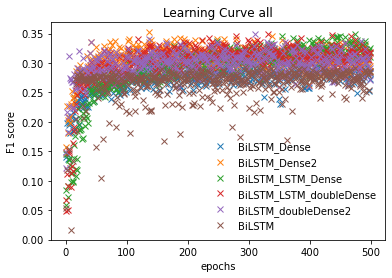

In [48]:
plot_learning_curve(dataset_name)

In [49]:
df_results_DL_all = retrieve_minval_score(dataset_name)
df_results_DL_all

algorithm     F1 F1_val precision precision_val recall  \
0             BiLSTM_Dense  0.737  0.137     0.791         0.192  0.690   
1            BiLSTM_Dense2  0.740  0.181     0.790         0.210  0.696   
2        BiLSTM_LSTM_Dense  0.751  0.099     0.826         0.174  0.688   
3  BiLSTM_LSTM_doubleDense  0.770  0.116     0.852         0.231  0.701   
4      BiLSTM_doubleDense2  0.730  0.150     0.792         0.236  0.677   
5                   BiLSTM  0.638  0.218     0.691         0.237  0.592   

  recall_val  
0      0.107  
1      0.159  
2      0.069  
3      0.078  
4      0.110  
5      0.202

In [50]:
print(df_results_DL_all.to_latex(index=False))  

\begin{tabular}{lllllll}
\toprule
              algorithm &    F1 & F1\_val & precision & precision\_val & recall & recall\_val \\
\midrule
           BiLSTM\_Dense & 0.737 &  0.137 &     0.791 &         0.192 &  0.690 &      0.107 \\
          BiLSTM\_Dense2 & 0.740 &  0.181 &     0.790 &         0.210 &  0.696 &      0.159 \\
      BiLSTM\_LSTM\_Dense & 0.751 &  0.099 &     0.826 &         0.174 &  0.688 &      0.069 \\
BiLSTM\_LSTM\_doubleDense & 0.770 &  0.116 &     0.852 &         0.231 &  0.701 &      0.078 \\
    BiLSTM\_doubleDense2 & 0.730 &  0.150 &     0.792 &         0.236 &  0.677 &      0.110 \\
                 BiLSTM & 0.638 &  0.218 &     0.691 &         0.237 &  0.592 &      0.202 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_29329/3452084263.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_results_DL_all.to_latex(index=False))


**Probably in the all dataset something went wrong** --> it's the general behaviour when training on one data set and evaluating on the others

**Thoughts:**
- Evtl just too many brazil gaz data which is dominating everything
- Can test this by only training on brazil gaz and the evaluating on the different sets

# Debugging Code to be ignored

In [200]:
features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]
X_train, X_test, y_train, y_test, X_DL_train, X_DL_test = load_MLevaluation_data(dataset_name, features_ML)

In [9]:
tud_results = []

for model_name, model_factory in models: 
    
    for fold in range(num_folds):
        
        checkpoint_filepath = Path(f"../results/model_evaluation/{brazil_gaz}/{model_name}/kfold_{fold}/checkpoints")
        assert checkpoint_filepath.exists()
        
        model = model_factory()
        model.load_weights(checkpoint_filepath) 
        
        
        
    
    tud_results.append({"model": model_name, "num_params": })

SyntaxError: invalid syntax (3563665805.py, line 16)

In [6]:
tud_dir = Path("../Daten/data_to_use") # susbstitute real TUD datapath here
assert tud_dir.exists()
results_dir = Path("/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/results/model_evaluation/all_10fold/")
assert results_dir.exists

In [7]:
SEED = 23
data_dir = Path("../Daten/data_to_use")
results_dir = Path("/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/results/model_evaluation/all_10fold/")
assert results_dir.exists()

In [8]:
X_static, X_recurrent, y = load_prepare_data_eval(data_dir, "all")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/notebooks/../src/deep_learning_functions.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_static['industry'].replace(datanames,[0, 1, 2, 3, 4], inplace=True)


In [38]:
checkpoint_filepath = Path("../results/model_evaluation/all_10fold/BiLSTM_Dense/kfold_1/checkpoints")
assert checkpoint_filepath.exists()

In [39]:
model = BiLSTMDenseModel()

In [40]:
model.load_weights(checkpoint_filepath)

In [73]:
inputs = [X_recurrent[3:100,:,:], X_static[3:100]]

In [43]:
X_static.shape

(3147, 10)

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
scaler = StandardScaler()

In [69]:
X_static = scaler.fit_transform(X_static)

In [71]:
X_static

array([[-0.82438207,  4.9395084 ,  0.07609652, ..., -0.3831533 ,
         1.0720338 ,  2.8504946 ],
       [-0.82438207, -0.18760447, -0.4174687 , ...,  0.3648041 ,
        -1.412315  ,  1.387098  ],
       [-0.82438207,  4.9395084 ,  0.06131296, ..., -0.27069983,
         1.1353087 ,  2.950928  ],
       ...,
       [ 1.7072895 , -0.59104943,  0.19982372, ..., -0.35321027,
         0.02266211, -0.8857313 ],
       [ 1.7072895 , -0.59104943,  0.56170624, ..., -0.2773772 ,
        -0.5926946 , -0.80051374],
       [ 1.7072895 , -0.59104943, -0.04134888, ..., -0.2850367 ,
        -0.5529614 , -0.80545646]], dtype=float32)

In [44]:
inputs = [tf.random.normal([20, 609, 1], seed = SEED), tf.random.normal([20, 10], seed = SEED)]

In [54]:
print(y.sample(40))

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [37]:
model.build()

TypeError: build() takes 2 positional arguments but 3 were given

In [14]:
model.build(inputs.shape)

In [17]:
model.call(inputs[0:55,:,:])

<tf.Tensor: shape=(55, 1), dtype=float32, numpy=
array([[0.99810094],
       [0.4020304 ],
       [0.9977952 ],
       [0.998689  ],
       [0.9787684 ],
       [0.1843521 ],
       [0.63034344],
       [0.9743678 ],
       [0.1453309 ],
       [0.9558559 ],
       [0.6330274 ],
       [0.45468178],
       [0.972349  ],
       [0.10967927],
       [0.96803343],
       [0.5271735 ],
       [0.9883106 ],
       [0.2699795 ],
       [0.9910103 ],
       [0.70893955],
       [0.942231  ],
       [0.9394163 ],
       [0.5617823 ],
       [0.73968256],
       [0.48124984],
       [0.7812305 ],
       [0.7642409 ],
       [0.9603021 ],
       [0.797671  ],
       [0.89555395],
       [0.52743536],
       [0.8152931 ],
       [0.28499162],
       [0.99963975],
       [0.9997509 ],
       [0.31782785],
       [0.45794594],
       [0.9954272 ],
       [0.9980729 ],
       [0.7442098 ],
       [0.99363446],
       [0.63261443],
       [0.9995964 ],
       [0.3492029 ],
       [0.9912011 ],
      

In [15]:
model.call(inputs[0:20,:,:])

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[0.99810094],
       [0.4020304 ],
       [0.9977952 ],
       [0.998689  ],
       [0.9787684 ],
       [0.1843521 ],
       [0.63034344],
       [0.9743678 ],
       [0.1453309 ],
       [0.9558559 ],
       [0.6330274 ],
       [0.45468178],
       [0.972349  ],
       [0.10967927],
       [0.96803343],
       [0.5271735 ],
       [0.9883106 ],
       [0.2699795 ],
       [0.9910103 ],
       [0.70893955]], dtype=float32)>

In [16]:
model.call(inputs[0:10,:,:])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.99810094],
       [0.40203   ],
       [0.9977952 ],
       [0.998689  ],
       [0.9787684 ],
       [0.18435216],
       [0.63034356],
       [0.9743678 ],
       [0.14533098],
       [0.955856  ]], dtype=float32)>

In [ ]:
model = BiLSTMModel()
model.load_weights(checkpoint_filepath)
inputs = X_recurrent
model.build(inputs.shape)
output = model.call(inputs)

In [127]:
model2 = Bidirectional(
            LSTM(128, kernel_regularizer=regularizers.L2(0.01),
                 recurrent_regularizer=regularizers.L2(0.01), return_sequences=True), name="BIDIRECTIONAL_LAYER_1")

In [129]:
model2.call(input3[0:54,:,:])[0,:,:]

<tf.Tensor: shape=(609, 256), dtype=float32, numpy=
array([[-0.00555529,  0.00712416,  0.00284062, ..., -0.01462718,
        -0.00810911, -0.00398134],
       [ 0.02296668, -0.03632865, -0.01299003, ..., -0.0340155 ,
        -0.01315227, -0.03800542],
       [ 0.02555032, -0.04305671, -0.00990795, ..., -0.0293341 ,
        -0.01195643, -0.03011126],
       ...,
       [ 0.01232368, -0.02280384, -0.00135272, ..., -0.02194669,
        -0.00806985, -0.02942188],
       [ 0.03333708, -0.05795389, -0.01209492, ..., -0.02888642,
        -0.00862194, -0.04613728],
       [ 0.0383065 , -0.06887354, -0.01108455, ..., -0.01732299,
        -0.00490603, -0.02902342]], dtype=float32)>

In [130]:
model2.call(input3[0:20,:,:])[0,:,:]

<tf.Tensor: shape=(609, 256), dtype=float32, numpy=
array([[-0.02161996,  0.02470087,  0.01099855, ...,  0.00012203,
        -0.0031211 ,  0.01520321],
       [-0.00461206,  0.00654065, -0.00253745, ..., -0.01744065,
        -0.0079518 , -0.01591751],
       [-0.00299828,  0.00393454, -0.0032611 , ..., -0.01251135,
        -0.00644165, -0.00960893],
       ...,
       [-0.03567591,  0.03982931, -0.00747615, ..., -0.00761776,
        -0.00313721, -0.00913907],
       [-0.01254672,  0.01068379, -0.01924116, ..., -0.01440756,
        -0.00442649, -0.02307621],
       [-0.00048804, -0.00835427, -0.02138868, ..., -0.00665769,
        -0.00197977, -0.01110879]], dtype=float32)>

In [131]:
model2.call(input3[0:20,:,:])[0,:,:]

<tf.Tensor: shape=(609, 256), dtype=float32, numpy=
array([[-0.02161996,  0.02470087,  0.01099855, ...,  0.00012203,
        -0.0031211 ,  0.01520321],
       [-0.00461206,  0.00654065, -0.00253745, ..., -0.01744065,
        -0.0079518 , -0.01591751],
       [-0.00299828,  0.00393454, -0.0032611 , ..., -0.01251135,
        -0.00644165, -0.00960893],
       ...,
       [-0.03567591,  0.03982931, -0.00747615, ..., -0.00761776,
        -0.00313721, -0.00913907],
       [-0.01254672,  0.01068379, -0.01924116, ..., -0.01440756,
        -0.00442649, -0.02307621],
       [-0.00048804, -0.00835427, -0.02138868, ..., -0.00665769,
        -0.00197977, -0.01110879]], dtype=float32)>

In [121]:
model = BiLSTMModel()
model.load_weights(checkpoint_filepath)

In [122]:
inputs = X_recurrent[:50,:,:]#tf.random.normal([60, 609, 1], seed = SEED)
input2 = X_recurrent[:21,:,:]
input3 = tf.random.normal([60, 609, 1], seed = SEED)
model.build(X_recurrent.shape)
output = model.call(inputs)

In [114]:
output2 = model.rec_layer_one(input2)

In [123]:
output3 = model.rec_layer_one(input3[0:54,:,:])

In [124]:
output4 = model.rec_layer_one(input3[0:20,:,:])

In [125]:
output3[0,:,:]

<tf.Tensor: shape=(609, 256), dtype=float32, numpy=
array([[ 1.49011169e-06,  0.00000000e+00, -2.98023394e-07, ...,
        -4.77706529e-02, -2.23517532e-07, -1.14571514e-04],
       [-6.55659687e-06, -5.96046519e-08,  1.13248564e-06, ...,
        -7.59268105e-02, -1.93715167e-07, -2.57356442e-04],
       [-7.58480610e-06,  0.00000000e+00,  1.37090308e-06, ...,
        -7.04136565e-02, -2.08616356e-07, -2.24348361e-04],
       ...,
       [-3.85943076e-06,  2.98023224e-08,  6.85452449e-07, ...,
        -5.29859327e-02, -1.34110479e-07, -1.77342081e-04],
       [-1.00137804e-05,  0.00000000e+00,  1.78813298e-06, ...,
        -5.46142571e-02, -4.47034907e-08, -2.20038128e-04],
       [-1.18616072e-05,  2.98023224e-08,  2.14575812e-06, ...,
        -2.97460761e-02,  0.00000000e+00, -1.28168016e-04]], dtype=float32)>

In [126]:
output4[0,:,:]

<tf.Tensor: shape=(609, 256), dtype=float32, numpy=
array([[ 6.55878694e-06,  9.57642055e-09, -6.51450534e-07, ...,
         2.04896897e-01,  0.00000000e+00, -2.76131232e-06],
       [ 7.11212033e-06,  9.57642055e-09, -7.16057400e-07, ...,
         1.67063609e-01,  0.00000000e+00, -1.60841428e-05],
       [ 8.18622902e-06,  1.91528393e-08, -8.07584115e-07, ...,
         1.96565494e-01,  0.00000000e+00, -1.27101312e-05],
       ...,
       [ 1.03832444e-05,  1.91528393e-08, -9.74485602e-07, ...,
         6.78665796e-03,  0.00000000e+00, -1.24516455e-05],
       [ 8.57681152e-06,  1.91528393e-08, -8.29119756e-07, ...,
        -9.58839804e-03,  0.00000000e+00, -1.86192883e-05],
       [ 8.03976036e-06,  1.91528393e-08, -7.91432228e-07, ...,
         2.27085757e-03,  0.00000000e+00, -1.22883994e-05]], dtype=float32)>

In [ ]:
Bidirectional(
            LSTM(128, kernel_regularizer=regularizers.L2(0.01),
                 recurrent_regularizer=regularizers.L2(0.01), return_sequences=True), name="BIDIRECTIONAL_LAYER_1")

In [103]:
model.rec_layer_one(input2[0:1,:,:])

<tf.Tensor: shape=(1, 609, 256), dtype=float32, numpy=
array([[[-4.48391847e-06,  0.00000000e+00,  2.26122239e-07, ...,
         -4.19754386e-01,  8.92136676e-09, -9.48312081e-05],
        [-4.63040124e-06,  0.00000000e+00,  1.83051398e-07, ...,
         -4.33702171e-01,  8.92136676e-09, -8.21526119e-05],
        [-4.64667710e-06,  9.57642055e-09,  1.50748221e-07, ...,
         -4.23401713e-01,  8.92136676e-09, -7.81538256e-05],
        ...,
        [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
          5.67837283e-02,  0.00000000e+00, -1.03429775e-05],
        [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
          3.91822010e-02,  0.00000000e+00, -9.93938920e-06],
        [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
          2.08940487e-02,  0.00000000e+00, -7.65847471e-06]]],
      dtype=float32)>

In [98]:
output = model.rec_layer_one(inputs)

In [99]:
output2[0,:,:]

<tf.Tensor: shape=(609, 256), dtype=float32, numpy=
array([[-4.48391847e-06,  0.00000000e+00,  2.26122239e-07, ...,
        -4.19754386e-01,  8.92136676e-09, -9.48312081e-05],
       [-4.63040124e-06,  0.00000000e+00,  1.83051398e-07, ...,
        -4.33702171e-01,  8.92136676e-09, -8.21526119e-05],
       [-4.64667710e-06,  9.57642055e-09,  1.50748221e-07, ...,
        -4.23401713e-01,  8.92136676e-09, -7.81538256e-05],
       ...,
       [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
         5.67837283e-02,  0.00000000e+00, -1.03429775e-05],
       [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
         3.91822010e-02,  0.00000000e+00, -9.93938920e-06],
       [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
         2.08940487e-02,  0.00000000e+00, -7.65847471e-06]], dtype=float32)>

In [100]:
output[0,:,:]

<tf.Tensor: shape=(609, 256), dtype=float32, numpy=
array([[-4.48391847e-06,  0.00000000e+00,  2.26122239e-07, ...,
        -4.19754386e-01,  8.92136676e-09, -9.48312081e-05],
       [-4.63040124e-06,  0.00000000e+00,  1.83051398e-07, ...,
        -4.33702171e-01,  8.92136676e-09, -8.21526119e-05],
       [-4.64667710e-06,  9.57642055e-09,  1.50748221e-07, ...,
        -4.23401713e-01,  8.92136676e-09, -7.81538256e-05],
       ...,
       [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
         5.67837283e-02,  0.00000000e+00, -1.03429775e-05],
       [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
         3.91822010e-02,  0.00000000e+00, -9.93938920e-06],
       [ 9.13013719e-06,  1.91528393e-08, -8.82958943e-07, ...,
         2.08940487e-02,  0.00000000e+00, -7.65847471e-06]], dtype=float32)>

In [63]:
output

<tf.Tensor: shape=(61, 1), dtype=float32, numpy=
array([[0.69059336],
       [0.6471717 ],
       [0.6910492 ],
       [0.70067495],
       [0.6786522 ],
       [0.65997225],
       [0.62412703],
       [0.69946456],
       [0.65536773],
       [0.6914294 ],
       [0.6242949 ],
       [0.61868286],
       [0.68733764],
       [0.5294533 ],
       [0.68644625],
       [0.6139621 ],
       [0.6856747 ],
       [0.667509  ],
       [0.70688003],
       [0.64171755],
       [0.7142084 ],
       [0.6778704 ],
       [0.61271346],
       [0.6716692 ],
       [0.6252337 ],
       [0.65055615],
       [0.6488289 ],
       [0.69773734],
       [0.65077007],
       [0.65432477],
       [0.68485487],
       [0.6203085 ],
       [0.5466476 ],
       [0.7065236 ],
       [0.67312807],
       [0.6690804 ],
       [0.5515304 ],
       [0.6880304 ],
       [0.6604893 ],
       [0.625395  ],
       [0.6833508 ],
       [0.6318322 ],
       [0.68980736],
       [0.60962427],
       [0.71245974],
      

In [61]:
output

<tf.Tensor: shape=(60, 1), dtype=float32, numpy=
array([[0.69059336],
       [0.6471717 ],
       [0.6910492 ],
       [0.70067495],
       [0.6786522 ],
       [0.65997225],
       [0.62412703],
       [0.69946456],
       [0.65536773],
       [0.6914294 ],
       [0.6242949 ],
       [0.61868286],
       [0.68733764],
       [0.5294533 ],
       [0.68644625],
       [0.6139621 ],
       [0.6856747 ],
       [0.667509  ],
       [0.70688003],
       [0.64171755],
       [0.7142084 ],
       [0.6778704 ],
       [0.61271346],
       [0.6716692 ],
       [0.6252337 ],
       [0.65055615],
       [0.6488289 ],
       [0.69773734],
       [0.65077007],
       [0.65432477],
       [0.68485487],
       [0.6203085 ],
       [0.5466476 ],
       [0.7065236 ],
       [0.67312807],
       [0.6690804 ],
       [0.5515304 ],
       [0.6880304 ],
       [0.6604893 ],
       [0.625395  ],
       [0.6833508 ],
       [0.6318322 ],
       [0.68980736],
       [0.60962427],
       [0.71245974],
      

In [59]:
output

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.99810094],
       [0.40202984],
       [0.9977952 ],
       [0.998689  ],
       [0.9787684 ],
       [0.1843521 ],
       [0.63034344],
       [0.9743678 ],
       [0.14533088],
       [0.955856  ]], dtype=float32)>

In [57]:
output

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[0.99810094],
       [0.4020303 ],
       [0.9977952 ],
       [0.998689  ],
       [0.9787684 ],
       [0.18435206],
       [0.63034344],
       [0.9743678 ],
       [0.1453309 ],
       [0.9558559 ],
       [0.6330273 ],
       [0.4546813 ],
       [0.972349  ],
       [0.10967924],
       [0.96803343],
       [0.5271732 ],
       [0.9883106 ],
       [0.26997945],
       [0.9910103 ],
       [0.70893943]], dtype=float32)>

In [48]:
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02306042]], dtype=float32)>

In [49]:
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02306042]], dtype=float32)>

In [50]:
model.summary()

Model: "bi_lstm_model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BIDIRECTIONAL_LAYER_1 (Bidi  multiple                 133120    
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_1 (Dropout)   multiple                  0         
                                                                 
 BIDIRECTIONAL_LAYER_2 (Bidi  multiple                 164352    
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_2 (Dropout)   multiple                  0         
                                                                 
 DENSE_LAYER_1 (Dense)       multiple                  8256      
                                                                 
 DENSE_LAYER_2 (Dense)       multiple             

In [ ]:
model = BiLSTMModel()
model.load_weights(checkpoint_filepath)
inputs = X_recurrent
model.build(inputs.shape)
output = model.call(inputs)

In [33]:
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02306042]], dtype=float32)>

In [25]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [16]:
output

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.02306042],
       [0.03068547]], dtype=float32)>

In [20]:
model.build(inputs[:2,:,:].shape)

In [22]:
model.summary()

Model: "bi_lstm_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BIDIRECTIONAL_LAYER_1 (Bidi  multiple                 133120    
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_1 (Dropout)   multiple                  0         
                                                                 
 BIDIRECTIONAL_LAYER_2 (Bidi  multiple                 164352    
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_2 (Dropout)   multiple                  0         
                                                                 
 DENSE_LAYER_1 (Dense)       multiple                  8256      
                                                                 
 DENSE_LAYER_2 (Dense)       multiple              

In [12]:
model.load_weights(checkpoint_filepath)

In [ ]:
model.summary()

In [13]:
inputs = tf.random.normal([60, 609, 1], seed = SEED)

In [22]:
inputs.shape

TensorShape([60, 609, 1])

In [17]:
X_recurrent.shape

(3147, 609, 1)

In [13]:
X_recurrent[:20,:,:].shape

(20, 609, 1)

In [ ]:
output = model(X_recurrent)

In [29]:
output = model.call(inputs[:55,:,:])

In [30]:
output

<tf.Tensor: shape=(55, 1), dtype=float32, numpy=
array([[0.21636412],
       [0.15646738],
       [0.20352933],
       [0.22449991],
       [0.15918973],
       [0.1050432 ],
       [0.11182199],
       [0.23680803],
       [0.07356469],
       [0.16503584],
       [0.16228357],
       [0.12886621],
       [0.3081717 ],
       [0.21323447],
       [0.1703057 ],
       [0.1014256 ],
       [0.0527283 ],
       [0.09596054],
       [0.11115493],
       [0.15525793],
       [0.09558499],
       [0.30254203],
       [0.06042928],
       [0.2902353 ],
       [0.14628631],
       [0.1605168 ],
       [0.15646613],
       [0.12338378],
       [0.15822959],
       [0.12664637],
       [0.1199462 ],
       [0.3687013 ],
       [0.08460099],
       [0.15891823],
       [0.14685035],
       [0.13901047],
       [0.11093118],
       [0.20776246],
       [0.18110837],
       [0.1395334 ],
       [0.22482897],
       [0.06176651],
       [0.25212714],
       [0.08886838],
       [0.21016008],
      

In [28]:
output

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.5059865 ],
       [0.08357221],
       [0.3288374 ],
       [0.21891874],
       [0.2804548 ],
       [0.40023437],
       [0.3330375 ],
       [0.0258214 ],
       [0.20884664],
       [0.28400242],
       [0.04984081],
       [0.23569073],
       [0.5770708 ],
       [0.28458533],
       [0.0950551 ],
       [0.01947511],
       [0.30502945],
       [0.3756308 ],
       [0.00737378],
       [0.11503685],
       [0.3706974 ],
       [0.35958967],
       [0.0609419 ],
       [0.05198462],
       [0.01150264],
       [0.05781805],
       [0.03063346],
       [0.22687641],
       [0.41982108],
       [0.23578294],
       [0.20963843],
       [0.5321584 ],
       [0.28408906],
       [0.15395607],
       [0.162446  ],
       [0.953868  ],
       [0.27206483],
       [0.6222322 ],
       [0.28398806],
       [0.3025121 ],
       [0.520211  ],
       [0.24809413],
       [0.5931988 ],
       [0.4221436 ],
       [0.24053602],
      

In [26]:
output

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[0.5059865 ],
       [0.08357221],
       [0.3288374 ],
       [0.21891874],
       [0.2804548 ],
       [0.40023437],
       [0.3330375 ],
       [0.0258214 ],
       [0.20884664],
       [0.28400242],
       [0.04984081],
       [0.23569073],
       [0.5770708 ],
       [0.28458533],
       [0.0950551 ],
       [0.01947511],
       [0.30502945],
       [0.3756308 ],
       [0.00737378],
       [0.11503685]], dtype=float32)>

In [24]:
output

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.50598663],
       [0.08357221],
       [0.32883748],
       [0.21891892],
       [0.28045484],
       [0.40023437],
       [0.3330375 ],
       [0.02582145],
       [0.20884673],
       [0.28400242]], dtype=float32)>

In [49]:
X_recurrent.shape

(3147, 609, 1)

In [ ]:
[batch, timesteps, feature].

In [54]:
X_static.shape

(3147, 10)

In [62]:
np.asarray([X_recurrent[0]]).shape

(1, 609, 1)

In [29]:
np.array([X_static[0]]).shape

(1, 10)

In [32]:
np.array([X_recurrent[0]]).shape

(1, 609, 1)

In [41]:
output = model.call([np.array([X_recurrent[0]]), np.array([X_static[0]])])

ValueError: Input 0 of layer "DENSE_LAYER_1" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 10)

In [67]:
X_recurrent.shape

(3147, 609, 1)

In [82]:
y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [95]:
tf.__version__

'2.9.0'

In [101]:
X_recurrent[].shape

(53, 609, 1)

In [50]:
from deep_learning_functions import *

In [103]:
output = model(X_recurrent[])
output

<tf.Tensor: shape=(1049, 1), dtype=float32, numpy=
array([[0.4753904 ],
       [0.48194227],
       [0.40685177],
       ...,
       [0.32437217],
       [0.32240006],
       [0.32890952]], dtype=float32)>

In [42]:
output = model(X_recurrent[1:55])
output

ValueError: Exception encountered when calling layer "bi_lstm_dense_model_2" (type BiLSTMDenseModel).

Input 0 of layer "BIDIRECTIONAL_LAYER_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (609, 1)

Call arguments received by layer "bi_lstm_dense_model_2" (type BiLSTMDenseModel):
  • inputs=tf.Tensor(shape=(54, 609, 1), dtype=float32)
  • return_embeddings=False

In [109]:
output = model(np.array([X_recurrent[53]]))
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99978656]], dtype=float32)>

In [129]:
from numpy.random import choice

NameError: name 'shuffle' is not defined

In [125]:
X_recurrent.(50)

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [ ]:
output = model(np.array([X_recurrent[53]]))
output

In [138]:
output = model(X_recurrent[2:56])
output

<tf.Tensor: shape=(54, 1), dtype=float32, numpy=
array([[0.47559243],
       [0.48194227],
       [0.44757137],
       [0.44353408],
       [0.40685177],
       [0.4829162 ],
       [0.4372894 ],
       [0.47401536],
       [0.40695354],
       [0.40175468],
       [0.46835113],
       [0.34932446],
       [0.46667105],
       [0.39574483],
       [0.46371275],
       [0.45360583],
       [0.4947314 ],
       [0.41517654],
       [0.5141084 ],
       [0.45847076],
       [0.3917376 ],
       [0.44558868],
       [0.39789695],
       [0.42502612],
       [0.4240585 ],
       [0.47080413],
       [0.4253836 ],
       [0.43437427],
       [0.4554516 ],
       [0.39906272],
       [0.35929856],
       [0.49200913],
       [0.4552193 ],
       [0.43872666],
       [0.36009398],
       [0.4578353 ],
       [0.43810877],
       [0.40531406],
       [0.45466012],
       [0.41031557],
       [0.47841826],
       [0.38691768],
       [0.5059425 ],
       [0.433395  ],
       [0.47791156],
      

In [124]:
output = model(X_recurrent[36:90])
output

<tf.Tensor: shape=(54, 1), dtype=float32, numpy=
array([[0.36009398],
       [0.4578353 ],
       [0.43810877],
       [0.40531406],
       [0.45466012],
       [0.41031557],
       [0.47841826],
       [0.38691768],
       [0.5059425 ],
       [0.433395  ],
       [0.47791156],
       [0.3704683 ],
       [0.38480893],
       [0.4777019 ],
       [0.38769057],
       [0.44930387],
       [0.364406  ],
       [0.47494555],
       [0.3941604 ],
       [0.44234326],
       [0.37400714],
       [0.48900494],
       [0.419055  ],
       [0.41645715],
       [0.4954769 ],
       [0.4077768 ],
       [0.43245178],
       [0.42532223],
       [0.46755275],
       [0.38224506],
       [0.41283894],
       [0.4793043 ],
       [0.41317037],
       [0.37156293],
       [0.49085122],
       [0.4320444 ],
       [0.4329303 ],
       [0.38336444],
       [0.41978142],
       [0.3820673 ],
       [0.44758856],
       [0.39728194],
       [0.39784876],
       [0.44672024],
       [0.48964792],
      

In [121]:
output = model(X_recurrent[46:100])
output

<tf.Tensor: shape=(54, 1), dtype=float32, numpy=
array([[0.47791156],
       [0.3704683 ],
       [0.38480893],
       [0.4777019 ],
       [0.38769057],
       [0.44930387],
       [0.364406  ],
       [0.47494555],
       [0.3941604 ],
       [0.44234326],
       [0.37400714],
       [0.48900494],
       [0.419055  ],
       [0.41645715],
       [0.4954769 ],
       [0.4077768 ],
       [0.43245178],
       [0.42532223],
       [0.46755275],
       [0.38224506],
       [0.41283894],
       [0.4793043 ],
       [0.41317037],
       [0.37156293],
       [0.49085122],
       [0.4320444 ],
       [0.4329303 ],
       [0.38336444],
       [0.41978142],
       [0.3820673 ],
       [0.44758856],
       [0.39728194],
       [0.39784876],
       [0.44672024],
       [0.48964792],
       [0.39460292],
       [0.43844983],
       [0.39725304],
       [0.38852063],
       [0.37952745],
       [0.44583687],
       [0.3909398 ],
       [0.39024884],
       [0.3843982 ],
       [0.44060162],
      

In [19]:
output

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.96167046],
       [0.34431133]], dtype=float32)>

In [66]:
y[0]

1

In [68]:
model.summary()

Model: "bi_lstm_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BIDIRECTIONAL_LAYER_1 (Bidi  multiple                 133120    
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_1 (Dropout)   multiple                  0         
                                                                 
 BIDIRECTIONAL_LAYER_2 (Bidi  multiple                 164352    
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_2 (Dropout)   multiple                  0         
                                                                 
 DENSE_LAYER_1 (Dense)       multiple                  8256      
                                                                 
 DENSE_LAYER_2 (Dense)       multiple              

In [31]:
import h5py

In [67]:
print(output > 0.5)

tf.Tensor([[ True]], shape=(1, 1), dtype=bool)


In [10]:
checkpoint_filepath = Path("../results/model_evaluation/brazil_gaz/BiLSTM/kfold_0/checkpoints")
assert checkpoint_filepath.exists()

In [23]:
checkpoint_path = Path("../results/model_evaluation/brazil_gaz/BiLSTM/kfold_0")
assert checkpoint_path.exists()

In [6]:
model = BiLSTMModel()

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

In [45]:
test = pd.read_hdf(checkpoint_filepath)

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 620, in H5Fopen
    unable to open file
  File "H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "H5PLpath.c", line 620, in H5PL__path_table_iterate_process_path
    can't open directory: /opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/hdf5/plugin
  File "H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "H5Fint.c", line 1990, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 405, in H5F__super_read
    file signature not found

End of HDF5 error back trace

Unable to open/create file '../results/model_evaluation/brazil_gaz/BiLSTM/kfold_0/checkpoints.data-00000-of-00001'

In [7]:
model.load_weights(checkpoint_filepath)

NameError: name 'checkpoint_filepath' is not defined

In [48]:
model.summary()

Model: "bi_lstm_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BIDIRECTIONAL_LAYER_1 (Bidi  multiple                 0 (unused)
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_1 (Dropout)   multiple                  0 (unused)
                                                                 
 BIDIRECTIONAL_LAYER_2 (Bidi  multiple                 0 (unused)
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_2 (Dropout)   multiple                  0 (unused)
                                                                 
 DENSE_LAYER_1 (Dense)       multiple                  0 (unused)
                                                                 
 DENSE_LAYER_2 (Dense)       multiple              

In [ ]:
model.call()

In [9]:
model.set_weights(checkpoint_path)

NameError: name 'checkpoint_path' is not defined

In [38]:
model.built = True

In [11]:
model.load_weights(checkpoint_filepath)

In [12]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))